In [1]:
# -*- coding: utf-8 -*--
# @Time    : 2022-08-05 9:45
# @Author  : zhangbowen

In [2]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import random
from utils.utils import normalization, standardization, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
# standardization (distribution -> mean=0, std=1, [0, 1]/[-1, 1])
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
# Normalization (distribution -> constant, [0, 1])
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 1. Data preparation

#### read row data

In [3]:
data_path = r'data/raw_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False)
df.shape

(89383, 316)

#### options about label (power harassment)
- B-16-61(仕事の内容は自分にあっている) <-- use this

#### defination of label's level (4-class problem)
- level 1: そうだ 
- level 2: まあそうだ
- level 3: ややちがう
- level 4: ちがう

In [4]:
for i in range(1, 5): 
    print('level {}: {}'.format(i, sum(df['B-16-61(仕事の内容は自分にあっている)']==i)))

level 1: 17552
level 2: 51175
level 3: 15779
level 4: 4877


#### label encoding (2-class problem)

In [5]:
# level 2, 3, 4 -> 0 (negative)
df['B-16-61(仕事の内容は自分にあっている)'].replace(to_replace=[2, 3, 4], value=0, inplace=True)
# level 1 -> 1 (positive)
df['B-16-61(仕事の内容は自分にあっている)'].replace(to_replace=1, value=1, inplace=True)

for i in range(2): 
    print('label {}: {}'.format(i, sum(df['B-16-61(仕事の内容は自分にあっている)']==i)))

label 0: 71831
label 1: 17552


#### split features to category & numeric

In [6]:
category = [f for f in df.columns if df.dtypes[f] =='object'] 
numeric = [f for f in df.columns if df.dtypes[f] !='object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 26
numeric 290


#### correlation coeficient of numeric & label

In [7]:
threshold = 0.3
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
for numeric_column in numeric:
    x = df[numeric_column]
    y = df['B-16-61(仕事の内容は自分にあっている)']
    cov = ((x-x.mean()) * (y-y.mean())).mean()
    corrcoef = cov / (x.std() * y.std())
    if abs(corrcoef) >= threshold:  
        print('{}: {:.2f}'.format(numeric_column, corrcoef))

回答時_退職理由: -0.41
回答時_休職理由: -0.37
B-16-61(仕事の内容は自分にあっている): 1.00
B-17-65(働きがいのある仕事だ): -0.48
B-20-79(生き生きする): 0.31
B-56-221(仕事に満足だ): -0.39
B-61-241(仕事で自分の長所をのばす機会がある): 0.36
B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している): 0.31
B-79-313(仕事をしていると、活力がみなぎるように感じる): 0.34
B-80-317(自分の仕事に誇りを感じる): 0.39
B-173-812(困難な時でも粘り強く仕事ができる): 0.30
B-174-816(自分の仕事に意義や意味を感じる): 0.36
B-175-820(職務を全うし会社やチームに貢献できている): 0.30
B-176-824(今の仕事（業務）はきっと将来の自分のためになると感じる): 0.32
C-8-8(職業性ストレス簡易調査_ストレスの原因と考えられる要素_仕事適正): 0.87
C-9-9(職業性ストレス簡易調査_ストレスの原因と考えられる要素_働きがい): 0.56
C-14-14(職業性ストレス簡易調査_ストレスによっておこる心身の反応_抑うつ感): 0.32
C-19-19(職業性ストレス簡易調査_ストレス反応に影響を与える他の因子_生活満足): 0.38
C-21-21(職業性ストレス簡易調査_合計点数_合計点数): 0.46
C-23-23(新職業性ストレス簡易調査_いきいきアウトカム_ワークエンゲイジメント): 0.40
C-34-34(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の適性): 0.71
C-36-36(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の意義): 0.48
C-38-38(新職業性ストレス簡易調査_仕事の資源（作業レベル）_成長の機会): 0.36
C-55-55(新職業性ストレス簡易調査_仕事の資源（事業所レベル）_ワーク・セルフ・バランス（ポジティブ）): 0.31
C-56-56(新職業性ストレス簡易調査_心身の健康_活気): 0.32
C-60-60(新職業性ストレス簡易調査_心身の健康_抑うつ感): 0.31
C-63-63(

#### features selection

#### objective features まだ　

In [8]:
# ######### objective/categorical features ##########
# '業種大分類名称',
# '業種中分類名称', 
# '性別',
# '血液型', 
# '誕生年',
# '入社年',
# '学歴名称',
# '雇用形態名称',
# '勤務形態名称',
# '職種名称',
# '個人年収名称',
# '世帯年収名称',
# '結婚名称',
# '介護名称',
# '怪我／病気名称',
# '精神科受診歴名称', 
# '入社形態名称',
# '勤務場所名称',


# ######### subjective/numeric features ##########
# B-17-65(働きがいのある仕事だ): -0.48
# B-20-79(生き生きする): 0.31
# B-56-221(仕事に満足だ): -0.39
# B-61-241(仕事で自分の長所をのばす機会がある): 0.36
# B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している): 0.31
# B-79-313(仕事をしていると、活力がみなぎるように感じる): 0.34
# B-80-317(自分の仕事に誇りを感じる): 0.39
# B-173-812(困難な時でも粘り強く仕事ができる): 0.30
# B-174-816(自分の仕事に意義や意味を感じる): 0.36
# B-175-820(職務を全うし会社やチームに貢献できている): 0.30
# B-176-824(今の仕事（業務）はきっと将来の自分のためになると感じる): 0.32
# C-8-8(職業性ストレス簡易調査_ストレスの原因と考えられる要素_仕事適正): 0.87
# C-9-9(職業性ストレス簡易調査_ストレスの原因と考えられる要素_働きがい): 0.56
# C-14-14(職業性ストレス簡易調査_ストレスによっておこる心身の反応_抑うつ感): 0.32
# C-19-19(職業性ストレス簡易調査_ストレス反応に影響を与える他の因子_生活満足): 0.38
# C-23-23(新職業性ストレス簡易調査_いきいきアウトカム_ワークエンゲイジメント): 0.40
# C-34-34(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の適性): 0.71
# C-36-36(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の意義): 0.48
# C-38-38(新職業性ストレス簡易調査_仕事の資源（作業レベル）_成長の機会): 0.36
# C-55-55(新職業性ストレス簡易調査_仕事の資源（事業所レベル）_ワーク・セルフ・バランス（ポジティブ）): 0.31
# C-56-56(新職業性ストレス簡易調査_心身の健康_活気): 0.32
# C-60-60(新職業性ストレス簡易調査_心身の健康_抑うつ感): 0.31
# C-63-63(新職業性ストレス簡易調査_満足度_仕事満足度): 0.39
# C-65-65(職業性ストレス簡易調査_ストレスの原因と考えられる要素): 0.51
# C-66-66(職業性ストレス簡易調査_ストレスによっておこる心身の反応): 0.32
# C-68-68(新職業性ストレス簡易調査_いきいきアウトカム): 0.36
# C-70-70(新職業性ストレス簡易調査_仕事の資源（作業レベル）): 0.57
# C-73-73(新職業性ストレス簡易調査_心身の健康): 0.32

#### summarize features & label into a dataframe

In [9]:
new_df = pd.DataFrame(df, columns=[
    'B-17-65(働きがいのある仕事だ)', # features
    'B-20-79(生き生きする)',
    'B-56-221(仕事に満足だ)',
    'B-61-241(仕事で自分の長所をのばす機会がある)',
    'B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している)',
    'B-79-313(仕事をしていると、活力がみなぎるように感じる)',
    'B-80-317(自分の仕事に誇りを感じる)',
    'B-173-812(困難な時でも粘り強く仕事ができる)',
    'B-174-816(自分の仕事に意義や意味を感じる)',
    'B-175-820(職務を全うし会社やチームに貢献できている)',
    'B-176-824(今の仕事（業務）はきっと将来の自分のためになると感じる)',
    'C-8-8(職業性ストレス簡易調査_ストレスの原因と考えられる要素_仕事適正)',
    'C-9-9(職業性ストレス簡易調査_ストレスの原因と考えられる要素_働きがい)',
    'C-14-14(職業性ストレス簡易調査_ストレスによっておこる心身の反応_抑うつ感)',
    'C-19-19(職業性ストレス簡易調査_ストレス反応に影響を与える他の因子_生活満足)',
    'C-23-23(新職業性ストレス簡易調査_いきいきアウトカム_ワークエンゲイジメント)',
    'C-34-34(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の適性)',
    'C-36-36(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の意義)',
    'C-38-38(新職業性ストレス簡易調査_仕事の資源（作業レベル）_成長の機会)',
    'C-55-55(新職業性ストレス簡易調査_仕事の資源（事業所レベル）_ワーク・セルフ・バランス（ポジティブ）)',
    'C-56-56(新職業性ストレス簡易調査_心身の健康_活気)',
    'C-60-60(新職業性ストレス簡易調査_心身の健康_抑うつ感)',
    'C-63-63(新職業性ストレス簡易調査_満足度_仕事満足度)',
    'C-65-65(職業性ストレス簡易調査_ストレスの原因と考えられる要素)',
    'C-66-66(職業性ストレス簡易調査_ストレスによっておこる心身の反応)',
    'C-68-68(新職業性ストレス簡易調査_いきいきアウトカム)',
    'C-70-70(新職業性ストレス簡易調査_仕事の資源（作業レベル）)',
    'C-73-73(新職業性ストレス簡易調査_心身の健康)',
    'B-16-61(仕事の内容は自分にあっている)' # label
])

new_df.shape

(89383, 29)

#### feature & label names' datatype conversion

In [10]:
# japanese -> english
new_df = new_df.rename(columns={
    'B-17-65(働きがいのある仕事だ)':'X1', # features
    'B-20-79(生き生きする)':'X2',
    'B-56-221(仕事に満足だ)':'X3',
    'B-61-241(仕事で自分の長所をのばす機会がある)':'X4',
    'B-76-302(仕事でエネルギーをもらうことで、自分の生活がさらに充実している)':'X5',
    'B-79-313(仕事をしていると、活力がみなぎるように感じる)':'X6',
    'B-80-317(自分の仕事に誇りを感じる)':'X7',
    'B-173-812(困難な時でも粘り強く仕事ができる)':'X8',
    'B-174-816(自分の仕事に意義や意味を感じる)':'X9',
    'B-175-820(職務を全うし会社やチームに貢献できている)':'X10',
    'B-176-824(今の仕事（業務）はきっと将来の自分のためになると感じる)':'X11',
    'C-8-8(職業性ストレス簡易調査_ストレスの原因と考えられる要素_仕事適正)':'X12',
    'C-9-9(職業性ストレス簡易調査_ストレスの原因と考えられる要素_働きがい)':'X13',
    'C-14-14(職業性ストレス簡易調査_ストレスによっておこる心身の反応_抑うつ感)':'X14',
    'C-19-19(職業性ストレス簡易調査_ストレス反応に影響を与える他の因子_生活満足)':'X15',
    'C-23-23(新職業性ストレス簡易調査_いきいきアウトカム_ワークエンゲイジメント)':'X16',
    'C-34-34(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の適性)':'X17',
    'C-36-36(新職業性ストレス簡易調査_仕事の資源（作業レベル）_仕事の意義)':'X18',
    'C-38-38(新職業性ストレス簡易調査_仕事の資源（作業レベル）_成長の機会)':'X19',
    'C-55-55(新職業性ストレス簡易調査_仕事の資源（事業所レベル）_ワーク・セルフ・バランス（ポジティブ）)':'X20',
    'C-56-56(新職業性ストレス簡易調査_心身の健康_活気)':'X21',
    'C-60-60(新職業性ストレス簡易調査_心身の健康_抑うつ感)':'X22',
    'C-63-63(新職業性ストレス簡易調査_満足度_仕事満足度)':'X23',
    'C-65-65(職業性ストレス簡易調査_ストレスの原因と考えられる要素)':'X24',
    'C-66-66(職業性ストレス簡易調査_ストレスによっておこる心身の反応)':'X25',
    'C-68-68(新職業性ストレス簡易調査_いきいきアウトカム)':'X26',
    'C-70-70(新職業性ストレス簡易調査_仕事の資源（作業レベル）)':'X27',
    'C-73-73(新職業性ストレス簡易調査_心身の健康)':'X28',
    'B-16-61(仕事の内容は自分にあっている)':'Y' # label
})

# 2. Data analysis

In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89383 entries, 0 to 89382
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      89383 non-null  float64
 1   X2      89383 non-null  float64
 2   X3      89383 non-null  float64
 3   X4      89383 non-null  float64
 4   X5      89383 non-null  float64
 5   X6      89383 non-null  float64
 6   X7      89383 non-null  float64
 7   X8      89383 non-null  float64
 8   X9      89383 non-null  float64
 9   X10     89383 non-null  float64
 10  X11     89383 non-null  float64
 11  X12     89383 non-null  float64
 12  X13     89383 non-null  float64
 13  X14     89383 non-null  float64
 14  X15     89383 non-null  float64
 15  X16     89383 non-null  float64
 16  X17     89383 non-null  float64
 17  X18     89383 non-null  float64
 18  X19     89383 non-null  float64
 19  X20     89383 non-null  float64
 20  X21     89383 non-null  float64
 21  X22     89383 non-null  float64
 22

#### category: count(=sum of not missing data), unique(=set), top(=category of highest frequency), freq(=highest frequency)

In [12]:
# new_df.describe(include=['O'])

#### numeri: count, mean, std, min, 25%, 50%, 75%, max

In [13]:
new_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X20,X21,X22,X23,X24,X25,X26,X27,X28,Y
count,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,...,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000
mean,2.035935,2.543291,2.299632,2.810557,2.237159,2.312509,2.804023,2.970699,2.923196,2.900697,...,2.237159,2.584040,2.859741,2.700368,49.084811,42.780417,2.646541,2.922477,2.617555,0.196368
std,0.810491,0.852902,0.799376,0.799095,0.865807,0.838305,0.819752,0.671407,0.755739,0.673024,...,0.865807,0.781961,0.694786,0.799376,13.415944,19.924075,0.645509,0.513502,0.560209,0.397253
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,...,2.000000,2.000000,2.330000,2.000000,41.670000,29.170000,2.250000,2.610000,2.250000,0.000000
50%,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,2.670000,2.830000,3.000000,50.000000,41.670000,2.750000,2.950000,2.600000,0.000000
75%,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.330000,3.000000,58.330000,54.170000,3.000000,3.220000,2.980000,0.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,94.440000,100.000000,4.000000,4.000000,4.000000,1.000000


#### split features to category & numeric

In [14]:
category = [f for f in new_df.columns if new_df.dtypes[f] == 'object'] 
numeric = [f for f in new_df.columns if new_df.dtypes[f] != 'object']
print('category:', len(category))
# print(category)
print('numeric', len(numeric))
# print(numeric)

category: 0
numeric 29


#### relationship of numeric & label

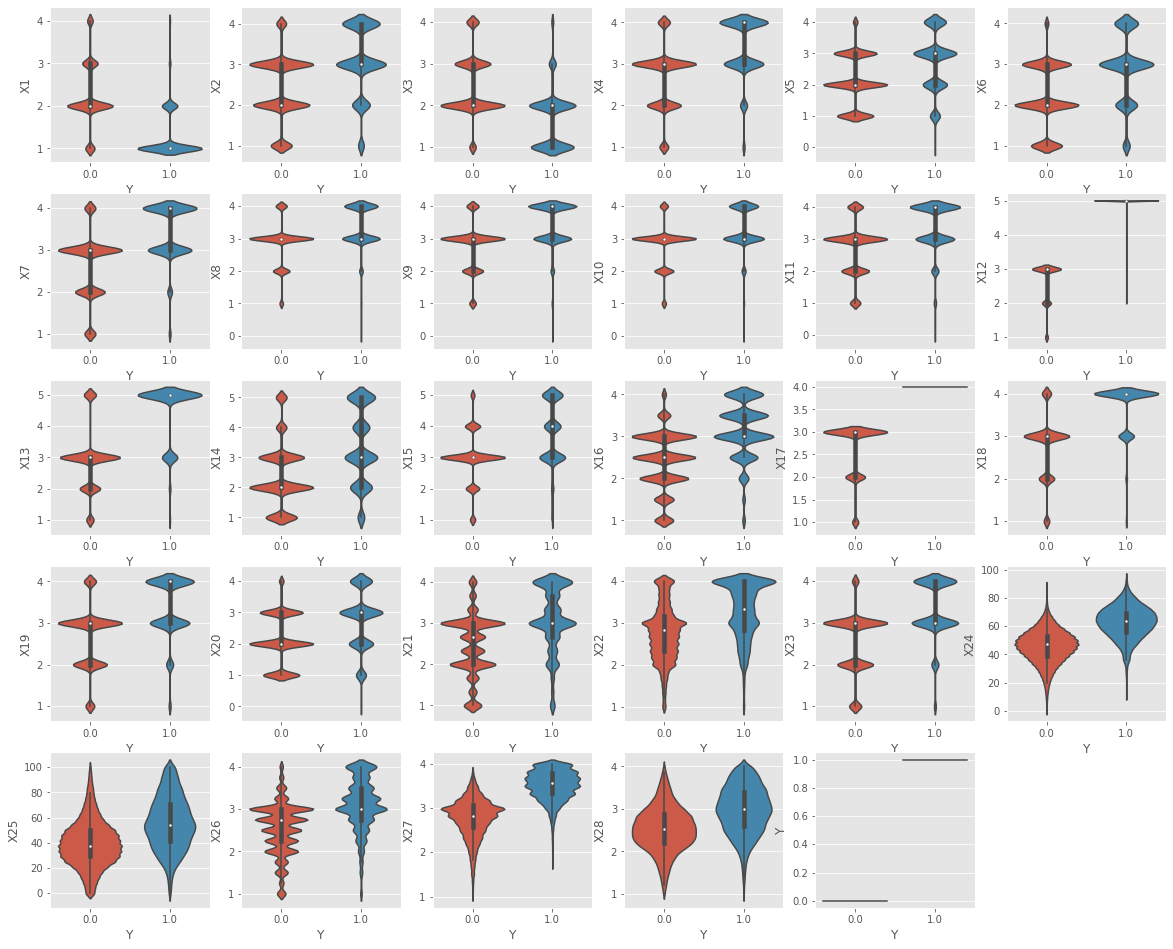

In [15]:
'''
sns.barplot() -> (mean)
sns.boxplot() -> (max, upper quartile, median, lower quartile, min)
sns.violinplot() -> (density distribution)
plt.scatter() -> (all datapoints)
sns.swarmplot -> (all datapoints)
'''
plt.figure(figsize=(20, 20))
for numeric_column in numeric:
    plt.subplot(6, 6, numeric.index(numeric_column)+1)
    sns.violinplot(data=new_df, x='Y', y=numeric_column)
plt.show()

#### distribution of numeric

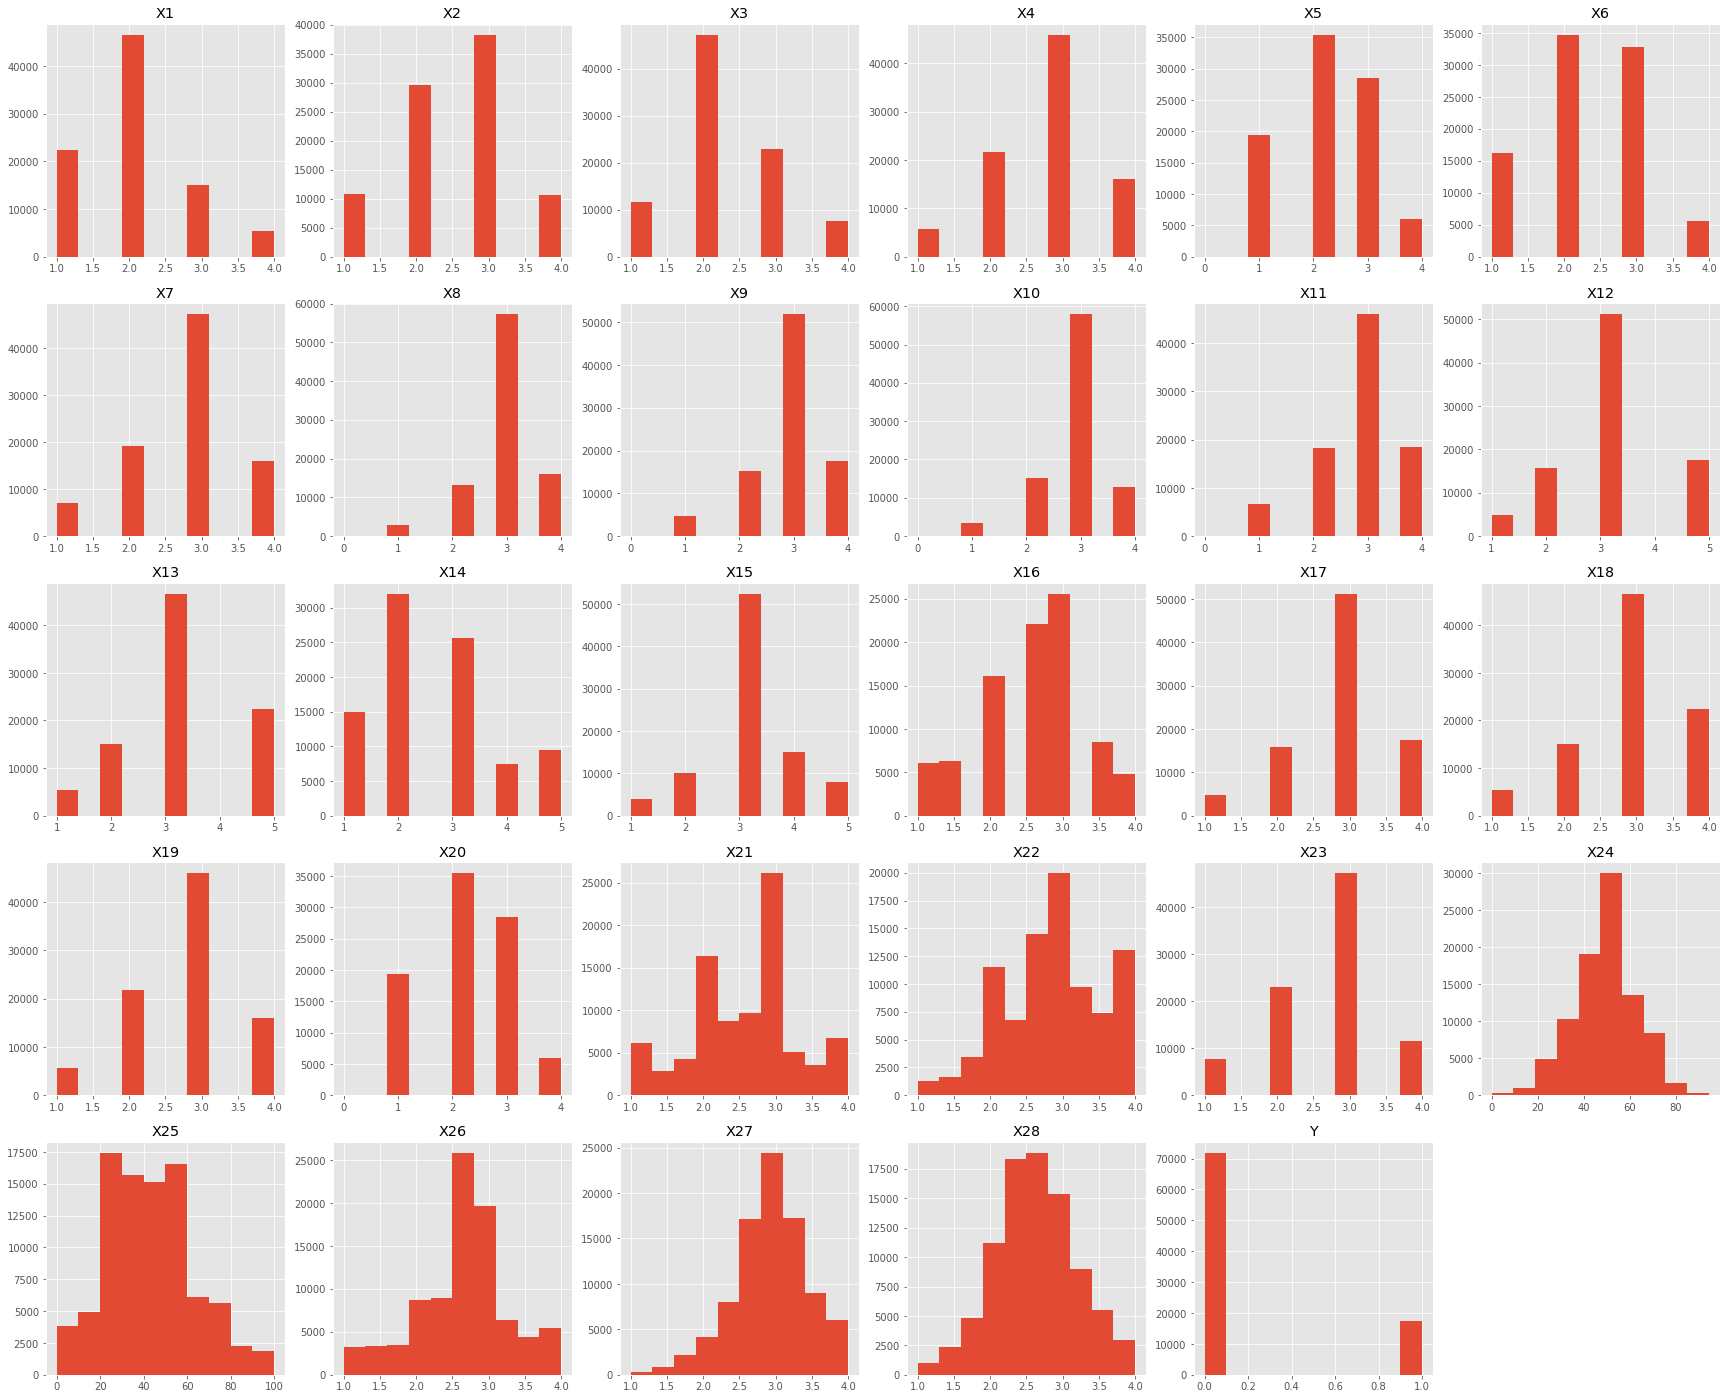

In [16]:
plt.figure(figsize=(30, 30))
for numeric_column in numeric:
    plt.subplot(6, 6, numeric.index(numeric_column)+1)
    plt.title(numeric_column)
    new_df[numeric_column].hist()
plt.show()

#### correlation coefficient of numeric & label

In [17]:
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
for numeric_column in numeric:
    x = new_df[numeric_column]
    y = new_df['Y']
    cov = ((x-x.mean()) * (y-y.mean())).mean()
    corrcoef = cov / (x.std() * y.std())
    print('{}: {:.2f}'.format(numeric_column, corrcoef))

X1: -0.48
X2: 0.31
X3: -0.39
X4: 0.36
X5: 0.31
X6: 0.34
X7: 0.39
X8: 0.30
X9: 0.36
X10: 0.30
X11: 0.32
X12: 0.87
X13: 0.56
X14: 0.32
X15: 0.38
X16: 0.40
X17: 0.71
X18: 0.48
X19: 0.36
X20: 0.31
X21: 0.32
X22: 0.31
X23: 0.39
X24: 0.51
X25: 0.32
X26: 0.36
X27: 0.57
X28: 0.32
Y: 1.00


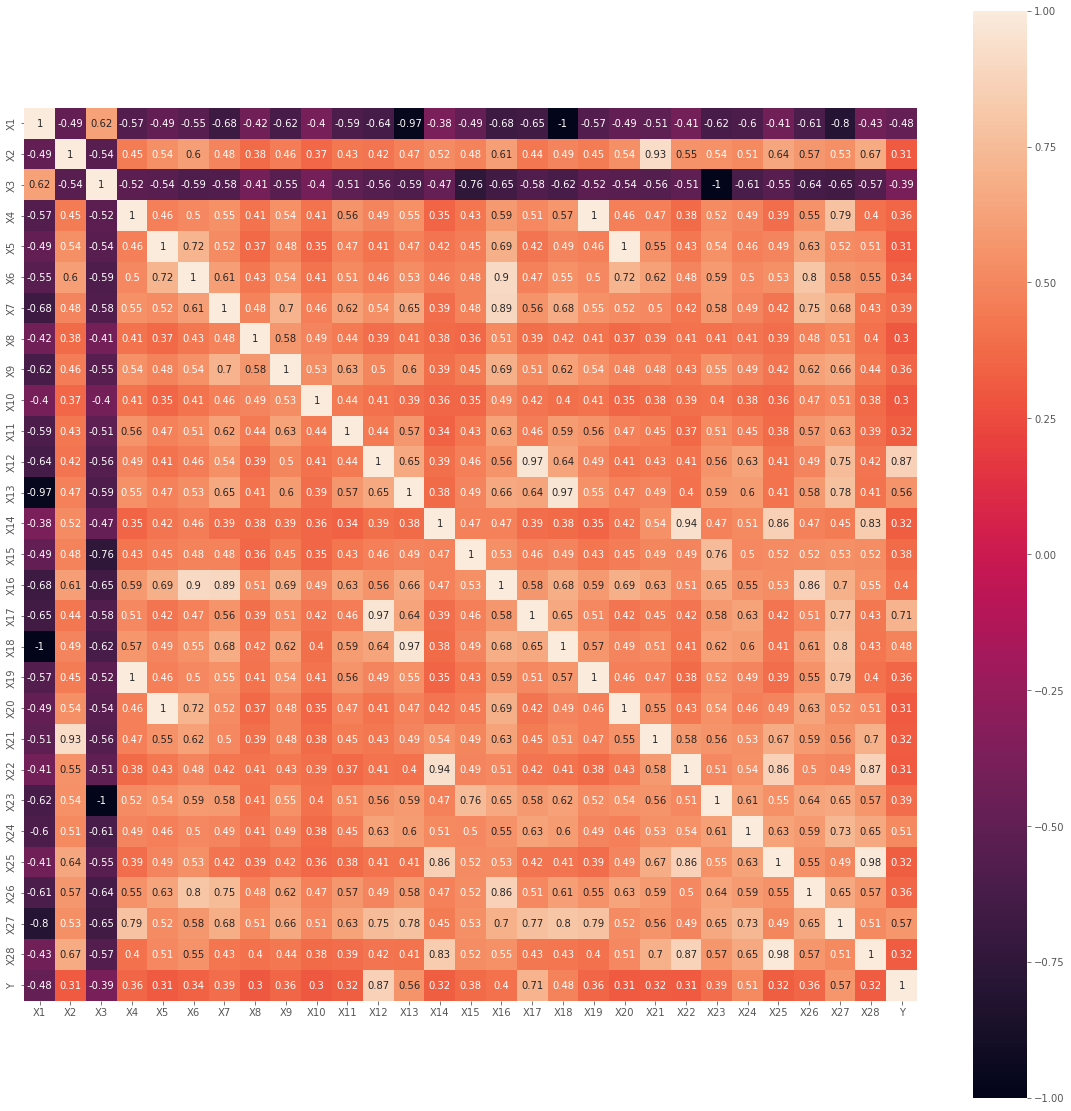

In [18]:
corrcoef_matrix = new_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrcoef_matrix, annot=True, square=True)
plt.show()

# 3. Data preprocessing

#### remove correlation coefficient > 0.9 features

In [19]:
new_df = new_df.drop(columns=['X13', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X25', 'X28'])

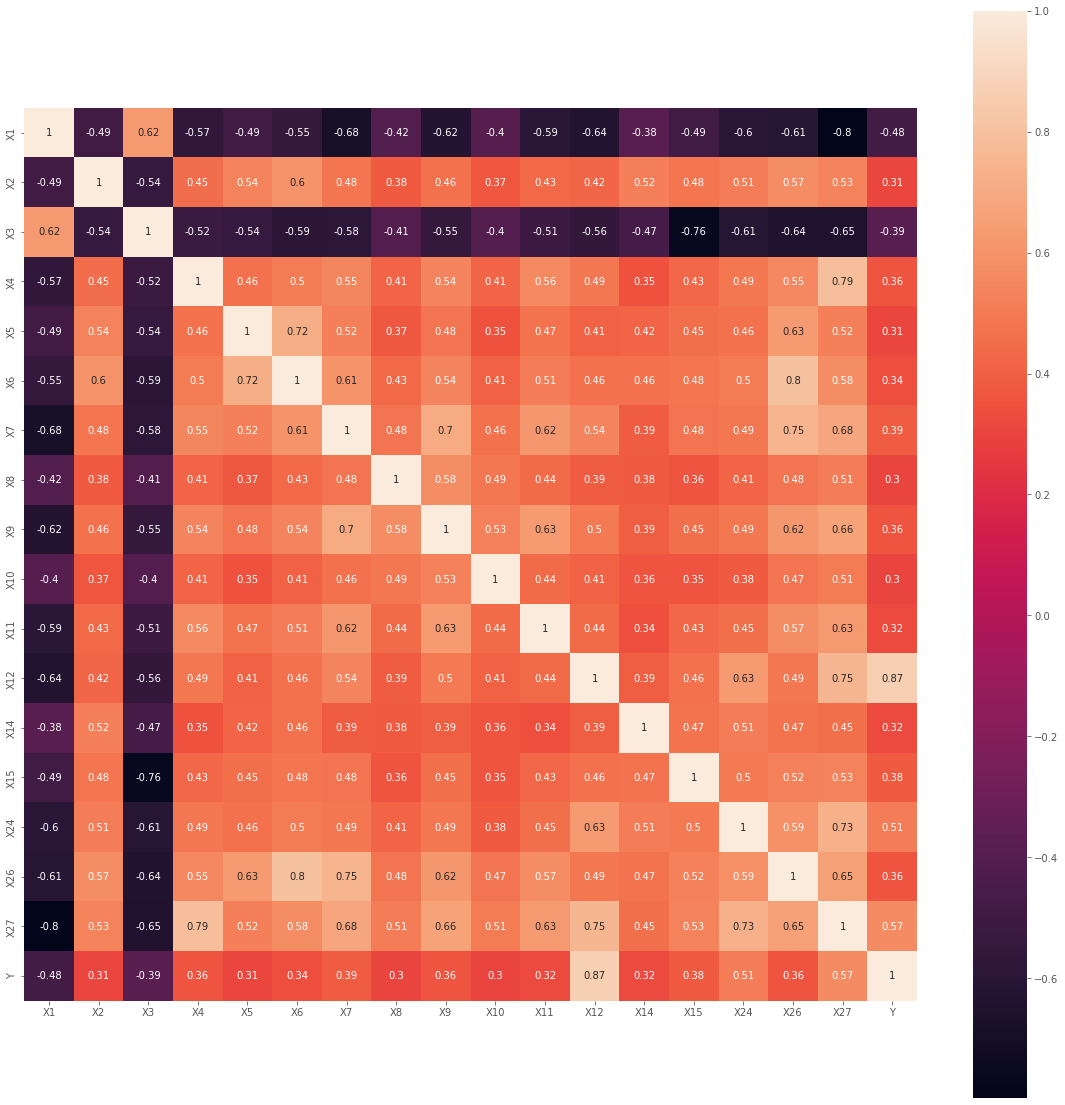

In [20]:
corrcoef_matrix = new_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrcoef_matrix, annot=True, square=True)
plt.show()

#### outliers data

In [20]:
# new_df.drop(new_df[new_df['Age']>65].index, inplace=True)

#### standardization & normalization of numeric

In [21]:
scaler = MinMaxScaler()
norm_list = list(new_df.columns)

for column in norm_list:
    new_df[column] = scaler.fit_transform(new_df[column].values.reshape(-1, 1))  

In [22]:
new_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X14,X15,X24,X26,X27,Y
count,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000,89383.000000
mean,0.345312,0.514430,0.433211,0.603519,0.559290,0.437503,0.601341,0.742675,0.730799,0.725174,0.713231,0.526736,0.400442,0.538005,0.519746,0.548847,0.640826,0.196368
std,0.270164,0.284301,0.266459,0.266365,0.216452,0.279435,0.273251,0.167852,0.188935,0.168256,0.207593,0.270274,0.292764,0.222152,0.142058,0.215170,0.171167,0.397253
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.333333,0.333333,0.500000,0.333333,0.333333,0.750000,0.750000,0.750000,0.500000,0.500000,0.250000,0.500000,0.441233,0.416667,0.536667,0.000000
50%,0.333333,0.666667,0.333333,0.666667,0.500000,0.333333,0.666667,0.750000,0.750000,0.750000,0.750000,0.500000,0.250000,0.500000,0.529437,0.583333,0.650000,0.000000
75%,0.333333,0.666667,0.666667,0.666667,0.750000,0.666667,0.666667,0.750000,0.750000,0.750000,0.750000,0.500000,0.500000,0.750000,0.617641,0.666667,0.740000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4. Feature selection

#### check feature importance via Lasso

feature importance via Lasso
     Feature Importance
X12            1.431183
X3             0.168530
X15            0.101129
X14            0.011231
X1             0.000000
X10           -0.000000
X26            0.000000
X24            0.000000
X11           -0.000000
X9            -0.000000
X2            -0.000000
X8             0.000000
X6            -0.000000
X5             0.000000
X4             0.000000
X7            -0.045160
X27           -0.208129


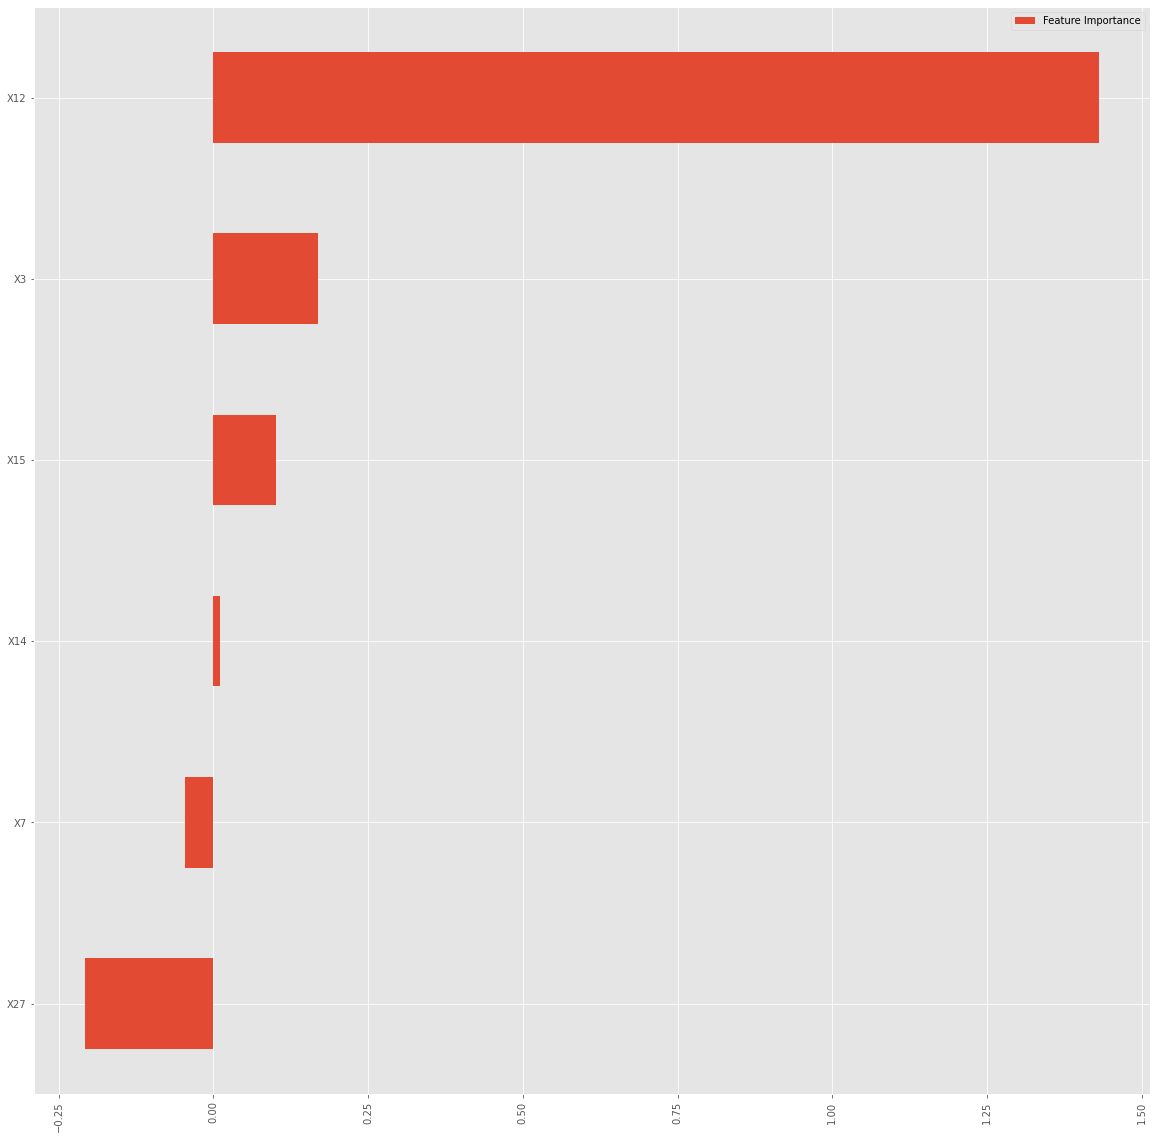

In [23]:
lasso=Lasso(alpha=0.001) # if alpha is so large, coefficients tend to become 0
lasso.fit(new_df.iloc[:, 0:-1], new_df.iloc[:, -1])

FI_lasso = pd.DataFrame({'Feature Importance':lasso.coef_}, index=new_df.columns[0: -1])
print('feature importance via Lasso')
# rank feature importance
print(FI_lasso.sort_values('Feature Importance', ascending=False))
# visualize feature importance
FI_lasso[FI_lasso['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh', figsize=(20, 20))
plt.xticks(rotation=90)
plt.show()

#### select only top n features to use

In [24]:
threshold = 0.05

ranked_features = FI_lasso.sort_values('Feature Importance', ascending=False)['Feature Importance']
selected_features = []
for key, value in ranked_features.items():
    if value >= threshold:
        selected_features.append(key)
    else:
        break
len(selected_features)

3

In [25]:
# selected_features.append('Y')
# new_df = new_df[selected_features]
# new_df

# 5. label balance

#### current balance (4-class)

In [26]:
# a = new_df.loc[new_df['Y']==1].count()[0]
# b = new_df.loc[new_df['Y']==2].count()[0]
# c = new_df.loc[new_df['Y']==3].count()[0]
# d = new_df.loc[new_df['Y']==4].count()[0]
# values = [a, b, c, d]
# labels = ['level 1', 'level 2', 'level 3', 'level 4']
# explode = [0.2, 0.2, 0.2, 0.2]

# def make_autopct(values):
#     def my_autopct(pct):
#         total = sum(values)
#         val = int(round(pct*total/100.0))
#         return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
#     return my_autopct
# plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
# plt.show()

#### current balance (2-class)

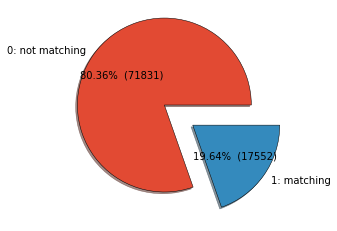

In [27]:
a = new_df.loc[new_df['Y']==0].count()[0]
b = new_df.loc[new_df['Y']==1].count()[0]
values = [a, b]
labels = ['0: not matching', '1: matching']
explode = [0.2, 0.2]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### downsampling (4-class)

In [28]:
# # 1
# new_df_1 = new_df[new_df['Y']==1].iloc[np.random.randint(0, a, size=d)]
# # 2
# new_df_2 = new_df[new_df['Y']==2].iloc[np.random.randint(0, b, size=d)]
# # 3
# new_df_3 = new_df[new_df['Y']==3].iloc[np.random.randint(0, c, size=d)]
# # 4
# new_df_4 = new_df[new_df['Y']==4]
# # merge
# new_df = pd.concat([new_df_1, new_df_2, new_df_3, new_df_4])


# a = new_df.loc[new_df['Y']==1].count()[0]
# b = new_df.loc[new_df['Y']==2].count()[0]
# c = new_df.loc[new_df['Y']==3].count()[0]
# d = new_df.loc[new_df['Y']==4].count()[0]
# values = [a, b, c, d]
# labels = ['level 1', 'level 2', 'level 3', 'level 4']
# explode = [0, 0, 0, 0]

# def make_autopct(values):
#     def my_autopct(pct):
#         total = sum(values)
#         val = int(round(pct*total/100.0))
#         return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
#     return my_autopct
# plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
# plt.show()

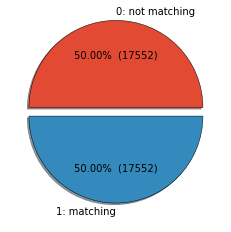

In [29]:
# 0: negative
final_df_0 = new_df[new_df['Y']==0].iloc[np.random.randint(0, a, size=b)]
# 1: positive
final_df_1 = new_df[new_df['Y']==1]
# merge
final_df = pd.concat([final_df_0, final_df_1])


a = final_df.loc[final_df['Y']==0].count()[0]
b = final_df.loc[final_df['Y']==1].count()[0]
values = [a, b]
labels = ['0: not matching', '1: matching']
explode = [0.1, 0]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, explode=explode, shadow=True, startangle=0, autopct=make_autopct(values), wedgeprops={'edgecolor':'black'})
plt.show()

#### dataframe -> csv

In [30]:
# original number of data
final_df.to_csv('data/Matching/data_utf-8.csv', index=False) # index=False: no write index
# upsampled data
# sample_features.to_csv('data/data_utf-8.csv', index=True)

# 6. Load &  split data for training 

#### read pre-processed data

In [31]:
data_path = r'data/Matching/data_utf-8.csv' 
df = pd.read_csv(data_path, encoding='utf-8', low_memory=False) # for ignore DtypeWarningb
print(df.shape)
df.describe()

(35104, 18)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X14,X15,X24,X26,X27,Y
count,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000
mean,0.246401,0.581434,0.353492,0.676153,0.610073,0.508764,0.681822,0.780630,0.782190,0.764037,0.764272,0.704521,0.473244,0.602438,0.575466,0.607317,0.715320,0.500000
std,0.271825,0.295607,0.273619,0.273132,0.230022,0.293204,0.275089,0.171452,0.190283,0.172292,0.209112,0.314584,0.313809,0.241778,0.151331,0.222742,0.179410,0.500007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.333333,0.666667,0.500000,0.333333,0.666667,0.750000,0.750000,0.750000,0.750000,0.500000,0.250000,0.500000,0.470563,0.500000,0.610000,0.000000
50%,0.333333,0.666667,0.333333,0.666667,0.500000,0.666667,0.666667,0.750000,0.750000,0.750000,0.750000,0.500000,0.500000,0.500000,0.588310,0.666667,0.723333,0.500000
75%,0.333333,0.666667,0.333333,1.000000,0.750000,0.666667,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,0.750000,0.750000,0.676514,0.750000,0.853333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### split dataframe -> features & label -> train & test

In [32]:
features = df.iloc[:, 0:-1]
label = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1234, stratify=label)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28083, 17), (7021, 17), (28083,), (7021,))

# 7. PCA

In [33]:
# model
pca = PCA(n_components=3, random_state=1234)
# train
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((28083, 3), (7021, 3))

#### visualize PC distribution

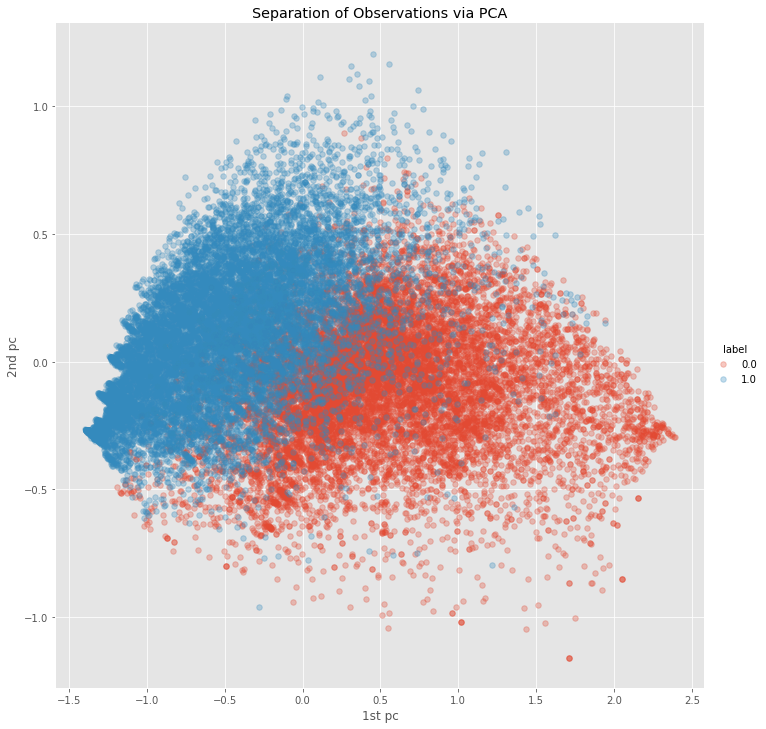

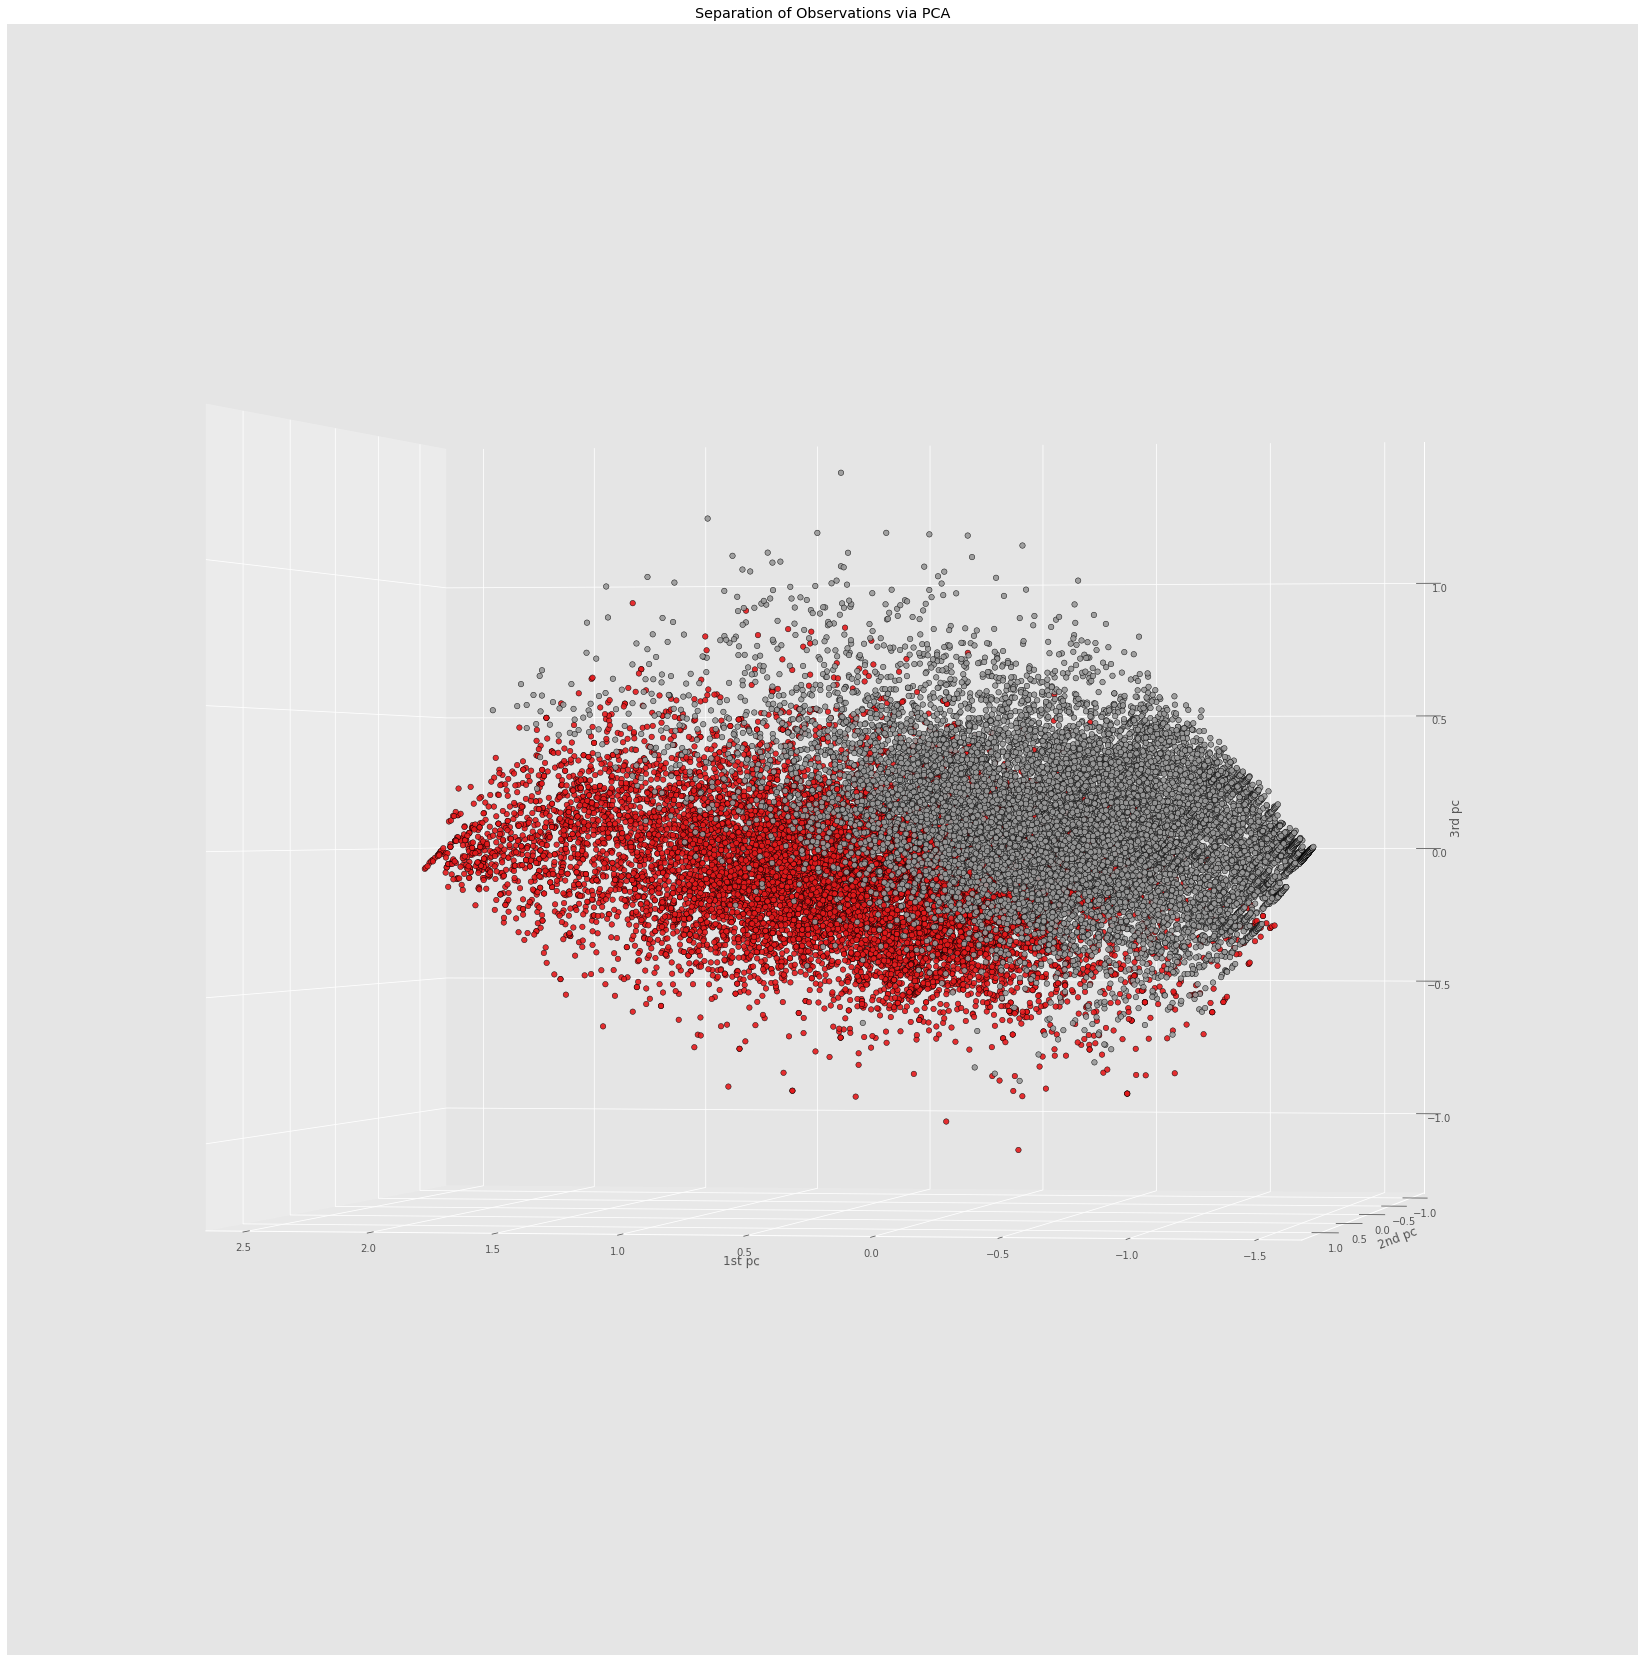

In [34]:
# plot 2D
def plot_2d_pc(xDF, yDF, first_PC, second_PC, algoName):
    tempDF = pd.DataFrame(data=pd.concat((xDF.loc[:, first_PC], xDF.loc[:, second_PC]), axis=1, join='inner'), index=xDF.index)

    tempDF = pd.concat((tempDF, yDF), axis=1, join='inner')
    tempDF.columns = ['1st pc', '2nd pc', 'label']

    sns.lmplot(x='1st pc', y='2nd pc', hue='label',
            data=tempDF, fit_reg=False, height=10,
            scatter_kws={'alpha':0.3, 's':30}
    )
    ax = plt.gca()
    ax.set_title('Separation of Observations via ' + algoName)
    plt.show()


# plot 3D
def plot_3d_pc(xDF, yDF, first_PC, second_PC, third_PC, algoName):
    fig = plt.figure(1, figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d', elev=-0, azim=100)
    ax.set_xlabel('1st pc')
    ax.set_ylabel('2nd pc')
    ax.set_zlabel('3rd pc')
    ax.scatter(
        X_train_pca[:, first_PC],
        X_train_pca[:, second_PC],
        X_train_pca[:, third_PC],
        c=y_train, cmap=plt.cm.Set1, 
        edgecolor='k', s=30, alpha=0.9
    )

    ax.set_title('Separation of Observations via ' + algoName)
    plt.show()


# ndarray -> dataframe for visualization
df_X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

# plot 2D 
plot_2d_pc(df_X_train_pca, y_train, 0, 1, 'PCA')

# plot 3D 
plot_3d_pc(df_X_train_pca, y_train, 0, 1, 2, 'PCA')

#### dataframe --> ndarray

In [35]:
X_train, y_train, X_test, y_test = X_train.values, y_train.values, X_test.values, y_test.values

# original (not pca)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# pca
print(X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape)

(28083, 17) (28083,) (7021, 17) (7021,)
(28083, 3) (28083,) (7021, 3) (7021,)


# 8. Modeling & Evaluation (train)

#### classification

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


models = [LogisticRegression(), DecisionTreeClassifier(), XGBClassifier(),
          KNeighborsClassifier(), GaussianNB(), RandomForestClassifier()
]

names = ['LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier', 
         'KNeighborsClassifier', 'GaussianNB', 'RandomForestClassifier'
]

#### various score functions & K-folds Cross Validation
[avaliable metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [37]:
num_folds = 5

def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=num_folds)

    return acc

def balanced_acc_cv(model, X, y):
    balanced_acc = cross_val_score(model, X, y, scoring=make_scorer(balanced_accuracy_score), cv=num_folds)

    return balanced_acc

def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision', cv=num_folds)

    return precision


def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall', cv=num_folds)

    return recall


def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1', cv=num_folds)

    return f1_score


def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring=make_scorer(roc_auc_score), cv=num_folds)

    return auc

In [38]:
for name, model in zip(names, models):
    print('----------', name, '----------')
    
    # acc
    score = acc_cv(model, X_train, y_train)
    print('||{}||    ||acc||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # balanced acc
    score = balanced_acc_cv(model, X_train, y_train)
    print('||{}||    ||balanced_acc_cv||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # precision
    score = precision_cv(model, X_train_pca, y_train)
    print('||{}||    ||precision_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # recall
    score = recall_cv(model, X_train, y_train)
    print('||{}||    ||recall_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # f1-score
    score = f1_score_cv(model, X_train, y_train)
    print('||{}||    ||f1-score_weighted||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

    # auc
    score = auc_cv(model, X_train, y_train)
    print('||{}||    ||auc||    mean sore: {:.4f}    std score: {:.4f}'.format(name, score.mean(), score.std()))

---------- LogisticRegression ----------
||LogisticRegression||    ||acc||    mean sore: 0.9999    std score: 0.0001
||LogisticRegression||    ||balanced_acc_cv||    mean sore: 0.9999    std score: 0.0001
||LogisticRegression||    ||precision_weighted||    mean sore: 0.9635    std score: 0.0019
||LogisticRegression||    ||recall_weighted||    mean sore: 0.9998    std score: 0.0002
||LogisticRegression||    ||f1-score_weighted||    mean sore: 0.9999    std score: 0.0001
||LogisticRegression||    ||auc||    mean sore: 0.9999    std score: 0.0001
---------- DecisionTreeClassifier ----------
||DecisionTreeClassifier||    ||acc||    mean sore: 0.9999    std score: 0.0001
||DecisionTreeClassifier||    ||balanced_acc_cv||    mean sore: 0.9999    std score: 0.0001
||DecisionTreeClassifier||    ||precision_weighted||    mean sore: 0.9549    std score: 0.0032
||DecisionTreeClassifier||    ||recall_weighted||    mean sore: 0.9999    std score: 0.0002
||DecisionTreeClassifier||    ||f1-score_weigh

# 9. Hyperparameters Tuning & Evaluation (train & test)

#### Grid Search & Cross Validation

In [142]:
num_folds = 5
metrics = 'f1'

class GridSearch():
    def __init__(self, model):
        self.model = model
    
    
    def grid_get(self, X, y, param_grid):
        grid_search_CV = GridSearchCV(self.model, param_grid, cv=num_folds, scoring=metrics)
        grid_search_CV.fit(X, y)
        
        best_params = grid_search_CV.best_params_
        best_score = grid_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
        # grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        # print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

        
        return best_params


In [143]:
# GridSearch(LogisticRegression()).grid_get(X_train, y_train, {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})        
# GridSearch(SVC()).grid_get(X_train, y_train, {'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})
# GridSearch(LinearSVC()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})
# GridSearch(KNeighborsClassifier()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})
# GridSearch(GaussianNB()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})
# GridSearch(RandomForestClassifier()).grid_get(X_train, y_train, param_grid)
# GridSearch(ExtraTreesClassifier()).grid_get(X_train, y_train, {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

# DecisionTreeClassifier
param_grid = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}

model = DecisionTreeClassifier()
GridSearch(model).grid_get(X_train, y_train, param_grid)        

best params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
best score: 1.0


{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'splitter': 'random'}

In [144]:
# XGBClassifier
param_grid = {'eta':[0.01, 0.1, 1.0],
              'gamma':[0, 0.1], 
              'n_estimators':[10, 100],
              'max_depth':[2, 4], 
              'min_child_weigh':[1, 2],
              'nthread':[2]
}

model = XGBClassifier(verbosity=0)
GridSearch(model).grid_get(X_train, y_train, param_grid)

best params: {'eta': 1.0, 'gamma': 0, 'max_depth': 2, 'min_child_weigh': 1, 'n_estimators': 100, 'nthread': 2}
best score: 0.9999287622439894


{'eta': 1.0,
 'gamma': 0,
 'max_depth': 2,
 'min_child_weigh': 1,
 'n_estimators': 100,
 'nthread': 2}

#### Randomized Search  & Cross Validation

In [39]:
num_folds = 3
metrics = 'f1'

class RandomizedSearch():
    def __init__(self, model):
        self.model = model
    
    
    def grid_get(self, X, y, random_grid):
        randomized_search_CV = RandomizedSearchCV(
            estimator = model, 
            param_distributions = random_grid, 
            n_iter=100, 
            cv = num_folds, 
            scoring = metrics,
            verbose=2, 
            random_state=4321, 
            n_jobs=-1
        )       
        randomized_search_CV.fit(X, y)

        best_params = randomized_search_CV.best_params_
        best_score = randomized_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
    
        return best_params

In [40]:
# RandomForestClassifier
random_grid = {'n_estimators': [100,200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4], 
               'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=4321)
best_params = RandomizedSearch(model).grid_get(X_train, y_train, random_grid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
best score: 0.9998931433657129


========== train ==========
                 precision    recall  f1-score   support

0: not matching       1.00      1.00      1.00     14042
    1: matching       1.00      1.00      1.00     14041

       accuracy                           1.00     28083
      macro avg       1.00      1.00      1.00     28083
   weighted avg       1.00      1.00      1.00     28083



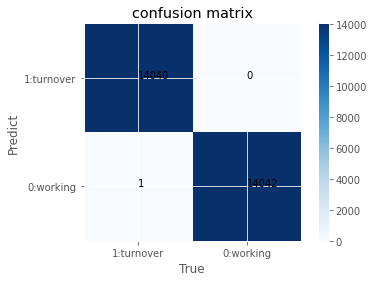

========== test ==========
                 precision    recall  f1-score   support

0: not matching       1.00      1.00      1.00      3510
    1: matching       1.00      1.00      1.00      3511

       accuracy                           1.00      7021
      macro avg       1.00      1.00      1.00      7021
   weighted avg       1.00      1.00      1.00      7021



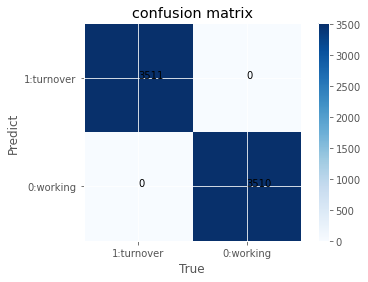

In [42]:
# train
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

# inference
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

labels = ['0: not matching', '1: matching']

# training score
print('========== train ==========')
print(classification_report(y_train, pred_train, target_names=labels))
confusion_matrix(y_train, pred_train)

# test score
print('========== test ==========')
print(classification_report(y_test, pred_test, target_names=labels))
confusion_matrix(y_test, pred_test)

#### evaluation on all (89383) data

In [46]:
X_train

array([[0.        , 1.        , 0.33333333, ..., 0.70595087, 0.83333333,
        0.94333333],
       [0.33333333, 0.66666667, 0.33333333, ..., 0.67651419, 0.66666667,
        0.63      ],
       [1.        , 0.        , 1.        , ..., 0.14707751, 0.        ,
        0.22333333],
       ...,
       [0.33333333, 0.        , 1.        , ..., 0.38235917, 0.33333333,
        0.61      ],
       [0.33333333, 0.66666667, 0.33333333, ..., 0.5       , 0.58333333,
        0.65      ],
       [0.66666667, 0.33333333, 0.66666667, ..., 0.5       , 0.5       ,
        0.39      ]])

(89383, 17) (89383,)
========== all(89383) ==========
                 precision    recall  f1-score   support

0: not matching       1.00      1.00      1.00     71831
    1: matching       1.00      1.00      1.00     17552

       accuracy                           1.00     89383
      macro avg       1.00      1.00      1.00     89383
   weighted avg       1.00      1.00      1.00     89383



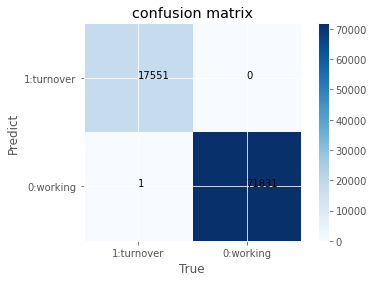

In [44]:
features = new_df.iloc[:, 0:-1]
label = new_df.iloc[:, -1]

print(features.shape, label.shape)

# inference
pred = model.predict(features)

# test score
print('========== all(89383) ==========')
print(classification_report(label, pred, target_names=labels))
confusion_matrix(label, pred)

# 10. model combination

# 11. submission

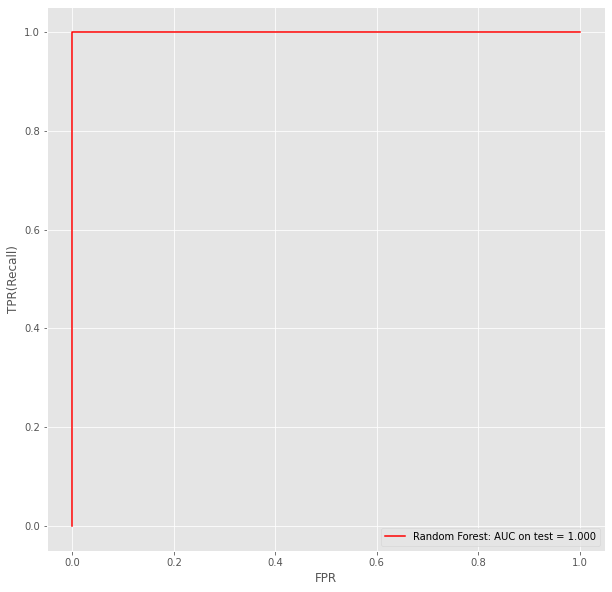

In [49]:
# calculate fpr & tpr
pred_prob = model.predict_proba(X_test)[:, 1] # [:, 1]: prob of label 1
FPR, TPR, thresholds = roc_curve(y_test, pred_prob)
# calculate AUC
AUC = auc(FPR, TPR)

plt.figure(figsize=(10,10))
plt.plot(FPR, TPR, 'r', label='Random Forest: AUC on test = %0.3f' % AUC)
# plt.plot(fpr_tree_clf, tpr_tree_clf, 'y', label = '决策树默认Val AUC = %0.3f' % roc_auc_tree_clf)
plt.xlabel('FPR')
plt.ylabel('TPR(Recall)')
plt.legend(loc=4)
plt.show()